
=== Image Generation Parameters ===
Press Enter to use default values or provide your own.

Enter your prompt (default: A hyper-realistic landscape at sunset, featuring majestic mountains with snow-capped peaks, a crysta...): girl walking on snow cloudy night
Enter negative prompt (default: blurry, low quality, distorted, unrealistic, artificial, cartoon, painting, drawing): high quality , realistic
Enter number of inference steps (default: 50): 60
Enter guidance scale (default: 7.5): 9
Enter image height (default: 512): 512
Enter image width (default: 512): 512


Generating images:   0%|          | 0/1 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

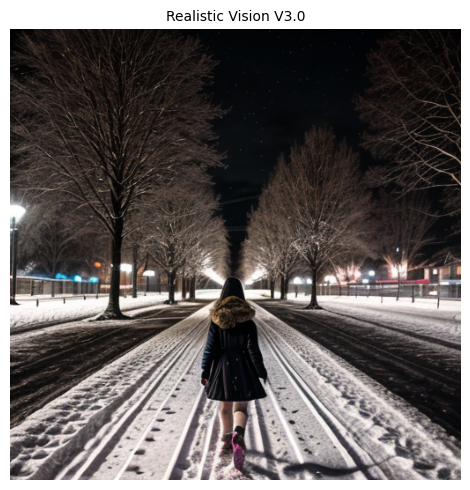

In [16]:
# --- 1. Install Required Libraries ---
# !pip install -q diffusers transformers accelerate torch pillow tqdm
# token = ""

#set you higging face token
# --- 2. Import Libraries ---
import os
import torch
import gc
from pathlib import Path
from datetime import datetime
from tqdm.notebook import tqdm
from diffusers import StableDiffusionPipeline
from PIL import Image
import matplotlib.pyplot as plt
from huggingface_hub import notebook_login

# Set up logging
import logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# --- 3. Hugging Face Login ---
#pass your hugging face token

notebook_login()

# --- 4. Model Dictionary ---
MODEL_DICT = {
    "Realistic Vision V3.0": "SG161222/Realistic_Vision_V3.0",
    # Add more models here as needed
}

# Create output directory
OUTPUT_DIR = Path("generated_images")
OUTPUT_DIR.mkdir(exist_ok=True)

# --- 5. Image Generation Class ---
class ImageGenerator:
    def __init__(self, model_id, device=None):
        self.model_id = model_id
        self.device = device or ("cuda" if torch.cuda.is_available() else "cpu")
        self.pipe = None

    def load_model(self):
        """Load the model and move it to the specified device."""
        try:
            logger.info(f"Loading model: {self.model_id}")
            self.pipe = StableDiffusionPipeline.from_pretrained(
                self.model_id,
                torch_dtype=torch.float16 if self.device == "cuda" else torch.float32,
            )
            self.pipe = self.pipe.to(self.device)
            return True
        except Exception as e:
            logger.error(f"Failed to load model {self.model_id}: {e}")
            return False

    def generate_image(self, prompt, num_inference_steps=50, guidance_scale=7.5,
                      height=512, width=512, seed=None, negative_prompt=None):
        """Generate an image based on the prompt and parameters."""
        if self.pipe is None and not self.load_model():
            return None

        try:
            # Set the seed for reproducibility
            generator = torch.manual_seed(seed) if seed is not None else None

            # Generate the image
            with torch.autocast(self.device):
                result = self.pipe(
                    prompt,
                    negative_prompt=negative_prompt,
                    num_inference_steps=num_inference_steps,
                    guidance_scale=guidance_scale,
                    height=height,
                    width=width,
                    generator=generator
                )

            return result.images[0]

        except Exception as e:
            logger.error(f"Failed to generate image: {e}")
            return None

    def cleanup(self):
        """Clean up resources."""
        if self.pipe is not None:
            del self.pipe
            self.pipe = None
        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

# --- 6. Default Parameters ---
DEFAULT_PARAMS = {
    "prompt": "A hyper-realistic landscape at sunset, featuring majestic mountains with snow-capped peaks, "
              "a crystal-clear river winding through the valley, surrounded by lush, dense forests with a "
              "variety of trees. The sky is painted with warm golden, orange, and purple hues, with dramatic "
              "clouds reflecting the last light of the sun. The foreground is detailed with vibrant green "
              "grass, rocks, and wildflowers. The lighting is soft but dramatic, with the sunlight filtering "
              "through the trees, casting long shadows and creating a peaceful, serene atmosphere. "
              "High-resolution textures, detailed reflections in the river, and natural lighting effects.",
    "negative_prompt": "blurry, low quality, distorted, unrealistic, artificial, cartoon, painting, drawing",
    "num_inference_steps": 50,
    "guidance_scale": 7.5,
    "height": 512,
    "width": 512,
}

# --- 7. Get User Input ---
def get_user_input():
    """Get user input for generation parameters with defaults."""
    print("\n=== Image Generation Parameters ===")
    print("Press Enter to use default values or provide your own.\n")

    # Get prompt
    prompt = input(f"Enter your prompt (default: {DEFAULT_PARAMS['prompt'][:100]}...): ").strip()
    if not prompt:
        prompt = DEFAULT_PARAMS['prompt']

    # Get negative prompt
    negative_prompt = input(f"Enter negative prompt (default: {DEFAULT_PARAMS['negative_prompt']}): ").strip()
    if not negative_prompt:
        negative_prompt = DEFAULT_PARAMS['negative_prompt']

    # Get numerical parameters
    try:
        num_inference_steps = input(f"Enter number of inference steps (default: {DEFAULT_PARAMS['num_inference_steps']}): ").strip()
        num_inference_steps = int(num_inference_steps) if num_inference_steps else DEFAULT_PARAMS['num_inference_steps']

        guidance_scale = input(f"Enter guidance scale (default: {DEFAULT_PARAMS['guidance_scale']}): ").strip()
        guidance_scale = float(guidance_scale) if guidance_scale else DEFAULT_PARAMS['guidance_scale']

        height = input(f"Enter image height (default: {DEFAULT_PARAMS['height']}): ").strip()
        height = int(height) if height else DEFAULT_PARAMS['height']

        width = input(f"Enter image width (default: {DEFAULT_PARAMS['width']}): ").strip()
        width = int(width) if width else DEFAULT_PARAMS['width']


    except ValueError as e:
        logger.error(f"Invalid input: {e}. Using default values.")
        return DEFAULT_PARAMS

    return {
        "prompt": prompt,
        "negative_prompt": negative_prompt,
        "num_inference_steps": num_inference_steps,
        "guidance_scale": guidance_scale,
        "height": height,
        "width": width,

    }

# --- 8. Generate Images ---
def generate_and_save_images(params):
    """Generate and save images using all models in the dictionary."""
    generated_images = []

    for model_name, model_id in tqdm(MODEL_DICT.items(), desc="Generating images"):
        generator = ImageGenerator(model_id)

        try:
            image = generator.generate_image(
                prompt=params["prompt"],
                negative_prompt=params["negative_prompt"],
                num_inference_steps=params["num_inference_steps"],
                guidance_scale=params["guidance_scale"],
                height=params["height"],
                width=params["width"],

            )

            if image is not None:
                # Save image with timestamp
                timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
                filename = f"{model_name.replace(' ', '_')}_{timestamp}.png"
                image_path = OUTPUT_DIR / filename
                image.save(image_path)
                logger.info(f"Image saved: {image_path}")
                generated_images.append((model_name, image))

        finally:
            generator.cleanup()

    return generated_images

# --- 9. Display Generated Images ---
def display_images(images):
    """Display all generated images in a grid."""
    if not images:
        logger.warning("No images to display")
        return

    n_images = len(images)
    fig, axes = plt.subplots(1, n_images, figsize=(5*n_images, 5))
    if n_images == 1:
        axes = [axes]

    for ax, (model_name, image) in zip(axes, images):
        ax.imshow(image)
        ax.axis('off')
        ax.set_title(model_name, fontsize=10)

    plt.tight_layout()
    plt.show()

# --- 10. Run Image Generation ---
if __name__ == "__main__":
    # Get user input for parameters
    generation_params = get_user_input()

    # Generate and display images
    generated_images = generate_and_save_images(generation_params)
    display_images(generated_images)

In [ ]:
DOne